<a href="https://colab.research.google.com/github/phamthien300820/CS114.K21/blob/master/Test_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Khai báo các thư viện cần thiết
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import os


In [5]:
%tensorflow_version 1.x

In [6]:

!pip3 install scipy
!pip3 install numpy
!pip3 install scipy
!pip3 install opencv-python
!pip3 install pillow
!pip3 install matplotlib
!pip3 install h5py
!pip3 install keras
!pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.1/imageai-2.0.1-py3-none-any.whl

     |████████████████████████████████| 143kB 809kB/s 


In [20]:
!cd drive
execution_path = os.getcwd()
execution_path

'/content'

In [11]:
from imageai.Detection import ObjectDetection
import os

execution_path = "/content/drive/My Drive/Colab Notebooks"

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.0.1.h5"))
detector.loadModel()

execution_path ="/content/drive/My Drive/Train/Have"
custom_objects = detector.CustomObjects(car=True, motorcycle=True)
detections = detector.detectCustomObjectsFromImage(custom_objects=custom_objects, input_image=os.path.join(execution_path,"IMG_20200620_074214.jpg"), output_image_path=os.path.join(execution_path,"IMG_20200620_074214_1.jpg"), minimum_percentage_probability=30)

for eachObject in detections:
    print(eachObject["name"] , " : ", eachObject["percentage_probability"])
    print("--------------------------------")

tracking <tf.Variable 'Variable_20:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_21:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_22:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_23:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_24:0' shape=(9, 4) dtype=float32> anchors
motorcycle  :  32.39491581916809
--------------------------------
motorcycle  :  46.950483322143555
--------------------------------


In [13]:

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [21]:
import cv2,os

data_path='/content/drive/My Drive/Train'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Have': 0, 'Not': 1}
['Have', 'Not']
[0, 1]


In [24]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(224,224))
            image = preprocess_input(resized)
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(image)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
           

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [26]:
import numpy as np

data=np.array(data)
data=np.reshape(data,(data.shape[0],224,224,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [27]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.2,random_state=42)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [31]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
print("[INFO] training head...")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
H = model.fit(
	aug.flow(train_data, train_target, batch_size=2),
	steps_per_epoch=len(train_data) // 2,
	validation_data=(test_data, test_target),
	validation_steps=len(test_data) // 2,
	epochs=3,callbacks=[checkpoint])

[INFO] training head...
Epoch 1/3
5/5 [==============================] - 8s 2s/step - loss: 4.0323 - accuracy: 0.8000 - val_loss: 1.5895e-07 - val_accuracy: 1.0000
Epoch 2/3
5/5 [==============================] - 6s 1s/step - loss: 0.3873 - accuracy: 0.9000 - val_loss: 0.1396 - val_accuracy: 1.0000
Epoch 3/3
5/5 [==============================] - 6s 1s/step - loss: 0.3688 - accuracy: 0.9000 - val_loss: 0.1488 - val_accuracy: 1.0000


In [38]:
predIdxs = model.predict(test_data, batch_size=2)

In [39]:
predIdxs = np.argmax(predIdxs)

ValueError: ignored

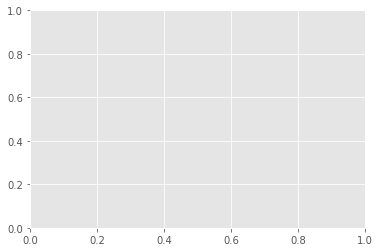

In [40]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")